In [1]:
import os
#os.chdir(os.path.abspath(os.path.join(__file__, os.pardir)))
#os.chdir(os.path.dirname(os.path.realpath(__file__)))
print(os.getcwd())
from __future__ import print_function
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; } .output_svg > div { width: 100% !important; height: 100% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.mpl_style = 'default'
import corpus, preprocessing, visualize

/mnt/DATA/DEVELOPING/PycharmProjects/recursive-dependency-embedding


/home/arne/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
import fnmatch, ntpath
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/sick/process_sentence3/SICK_CMaggregate'
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/ppdb/process_sentence3_ns1/PPDB_CMaggregate'
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/sick/process_sentence3/SICK_tt_CMaggregate'
train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence3/HASAN_CMaggregate_NEGSAMPLES0'
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence9/HASAN_CMaggregate'
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/sick/process_sentence9_ADJNOUN_orth/SICK_tt_CMaggregate'
parent_dir = os.path.abspath(os.path.join(train_data_path, os.pardir))
train_fnames = fnmatch.filter(os.listdir(parent_dir), ntpath.basename(train_data_path) + '.train.*')
train_fnames = [os.path.join(parent_dir, fn) for fn in train_fnames]
test_file_index = 1
test_fname = train_fnames[test_file_index]
del train_fnames[test_file_index] 
print('test file: '+ test_fname)
train_fnames

test file: /media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence3/HASAN_CMaggregate_NEGSAMPLES0.train.1


['/media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence3/HASAN_CMaggregate_NEGSAMPLES0.train.0']

In [3]:
import corpus
types = corpus.read_types(train_data_path)

In [4]:
import train_fold, similarity_tree_tuple_pb2

def data_iterator(filenames):
    return train_fold.iterate_over_tf_record_protos(
    filenames, similarity_tree_tuple_pb2.SimilarityTreeTuple, multiple_epochs=False)

In [5]:
from itertools import izip
def get_sentence_from_dep_sequence_node(dep_sequence_node):
    arrays = preprocessing.sequence_node_to_arrays(dep_sequence_node)
    texts = visualize.get_text(arrays, types)
    texts_pair = list(izip(*[iter(texts)]*2))
    return [b for (a,b) in texts_pair]

def get_child_ids_from_dep_sequence_node(dep_sequence_node):
    return [child['head'] for child in dep_sequence_node['children']]

In [6]:
#train_iterator = data_iterator(train_fnames[:-1])
train_iterator = data_iterator(train_fnames)
test_iterator = data_iterator([test_fname])

print('load test data ...')
#tuples_test = list(test_iterator)
#print('convert test data ...')
tuples_tokenids_test = [(get_child_ids_from_dep_sequence_node(similarity_tree_tuple['first']), get_child_ids_from_dep_sequence_node(similarity_tree_tuple['second']), similarity_tree_tuple['similarity']) for similarity_tree_tuple in test_iterator]
print(str(len(tuples_tokenids_test)))
print('load train data ...')
#tuples_train = list(train_iterator)
#print('convert train data ...')
tuples_tokenids_train = [(get_child_ids_from_dep_sequence_node(similarity_tree_tuple['first']), get_child_ids_from_dep_sequence_node(similarity_tree_tuple['second']), similarity_tree_tuple['similarity']) for similarity_tree_tuple in train_iterator]
print(str(len(tuples_tokenids_train)))

load test data ...
11542
load train data ...
11542


In [7]:
def ids_to_text(ids):
    return ' '.join([types[i] for i in ids])

print('convert train ids ...')
texts_train = [(ids_to_text(ids1), ids_to_text(ids2), sim) for ids1, ids2, sim in tuples_tokenids_train]
print('convert test ids ...')
texts_test = [(ids_to_text(ids1), ids_to_text(ids2), sim) for ids1, ids2, sim in tuples_tokenids_test]
texts_test[:10]

convert train ids ...
convert test ids ...


[(u'True however , we were all a fetus at one time , therefore , it is the beginning of life . A life that many families are dieing to take care of because they can not have children of their own .',
  u'But it is going to be life most people regret having abortion . Just because it is not completely formed does not mean it is alive . Why is it not okay to murder a kid at lets say 12 but its okay to kill a baby before it is even born ?',
  0.5),
 (u"Why am I a fool for thinking that ?    Because you are calling an entire group of people immoral for no other reason then that they are attracted to people of the same sex .   Because you do n't recognize that romantic love can exist outside of a heterosexual woman , and man .   Because you believe , without any actual basis , that homosexual parents are incapable of raising a child correctly .   Because when I ask you   why   these act are immoral , your only response is to quote a bible verse .   And most importantly you allow these basel

In [8]:
import math
def get_idfs(tuples):
    counts = {}
    for t in tuples:
        for tok_id in list(set(t[0])) + list(set(t[1])):
            c = counts.get(tok_id, 0)
            counts[tok_id] = c + 1
    result = {}
    for k in counts:
        result[k] = math.log(len(tuples)*2/counts[k])
    return result

idfs_test = get_idfs(tuples_tokenids_test)
tfidfs_dict = {k:i for i, k in enumerate(sorted(idfs_test))}

def get_tfidf(l, idfs):
    counts = {}
    for t in l:
        c = counts.get(t, 0) + idfs[t] / len(l)
        counts[t] = c
    return counts


tfidfs_test = [(get_tfidf(ids1, idfs_test), get_tfidf(ids2, idfs_test), sim) for ids1, ids2, sim in tuples_tokenids_test]


In [9]:
#from sklearn.feature_extraction import DictVectorizer
import numpy as np
from scipy.stats.stats import pearsonr

def to_vec(v_d, trans):
    result = np.zeros((len(trans),), dtype=float)
    for k in v_d:
        result[trans[k]] = v_d[k]
    return result    

def sim_tfidf(v1, v2):
    return np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)

tfidf_sim_test = np.array([sim_tfidf(to_vec(tfidf1, tfidfs_dict), to_vec(tfidf2, tfidfs_dict)) for tfidf1, tfidf2, sim in tfidfs_test])
gold_sim_test = np.array([sim for tfidf1, tfidf2, sim in tfidfs_test])
from scipy.stats.stats import pearsonr

# Person's r
print(pearsonr(tfidf_sim_test, gold_sim_test))
# MSE
np.square(tfidf_sim_test - gold_sim_test).mean()

(0.17357410798581185, 9.384843914328314e-79)


0.29132352635176334

In [11]:
from scipy.special import expit

# RANDOM basics (MSE, Perason's r)
# random (uniform distribution)
sampled = np.random.random_sample(size=len(gold_sim_test))
print(np.square(gold_sim_test - sampled).mean())
print(pearsonr(gold_sim_test, sampled))
# random (normal distribution, mean = 0.5)
sampled = np.random.normal(loc=0.5, size=len(gold_sim_test)).clip(0.0, 1.0)
print(np.square(gold_sim_test - sampled).mean())
print(pearsonr(gold_sim_test, sampled))
# random (normal distribution --> sigmoid) 
sampled = expit(np.random.normal(size=len(gold_sim_test)))
print(np.square(gold_sim_test - sampled).mean())
print(pearsonr(gold_sim_test, sampled))

0.162747577051
(-0.014678964858128737, 0.11481170947101493)
0.260135570394
(0.005002162610185967, 0.5910286381133173)
0.121145687266
(-0.0020131622620431834, 0.82878643811129704)


In [12]:
# corpus	Pearson	MSE

# RANDOM
# HASAN_ALL_orth_NEGSAMPLES0	-	0.160		# RANDOM uniform distribution
# HASAN_ALL_orth_NEGSAMPLES0	-	0.261		# RANDOM normal distribution, mean = 0.5
# HASAN_ALL_orth_NEGSAMPLES0	-	0.120		# RANDOM normal distribution --> sigmoid
# SICK_tt	-	0.165		# RANDOM uniform distribution
# SICK_tt	-	0.266		# RANDOM normal distribution, mean = 0.5
# SICK_tt	-	0.128		# RANDOM normal distribution --> sigmoid

# TFIDF
# SICK_VERBADJNOUN_lemma	0.611	0.091		# TFIDF
# SICK_ADJNOUN_lemma	0.558	0.111			# TFIDF
# SICK_VERBADJNOUN_orth	0.568	0.106		# TFIDF
# SICK_ADJNOUN_orth	0.542	0.119			# TFIDF
# HASAN_VERBADJNOUN_lemma	0.263	0.148		# TFIDF
# HASAN_ALL_orth_NEGSAMPLES1	0.288	0.145		# TFIDF
# HASAN_ALL_orth_NEGSAMPLES0	0.291	0.174		# TFIDF

# LSTM50
# SICK_tt_CMaggregate	0.8136	0.0236		# batchsize100_embeddingstrainableTRUE_learningrate0.001_optimizerADADELTAOPTIMIZER_simmeasureSIMCOSINE_statesize50_testfileindex1_traindatapathPROCESSSENTENCE3SICKTTCMAGGREGATE_treeembedderTREEEMBEDDINGFLATLSTM50
#NOTFINISHED # HASAN_NEGSAMPLES1	0.165	0.134		# batchsize100_embeddingstrainableTRUE_learningrate0.001_optimizerADADELTAOPTIMIZER_simmeasureSIMCOSINE_statesize50_testfileindex1_traindatapathPROCESSSENTENCE3HASANCMAGGREGATE_treeembedderTREEEMBEDDINGFLATLSTM50
#NOTFINISHED # HASAN_NEGSAMPLES0	0.151	0.094		# batchsize100_embeddingstrainableTRUE_learningrate0.001_optimizerADADELTAOPTIMIZER_simmeasureSIMCOSINE_statesize50_testfileindex1_traindatapathPROCESSSENTENCE3HASANCMAGGREGATENEGSAMPLES0_treeembedderTREEEMBEDDINGFLATLSTM

0.160848440083
1.07814849875


In [13]:
len_train = [len(ids1) + len(ids2) for ids1, ids2, sim in tuples_tokenids_train]
len_test = [len(ids1) + len(ids2) for ids1, ids2, sim in tuples_tokenids_test]
len_train_single = [len(ids1) for ids1, ids2, sim in tuples_tokenids_train] + [len(ids2) for ids1, ids2, sim in tuples_tokenids_train]
len_test_single = [len(ids1) for ids1, ids2, sim in tuples_tokenids_test] + [len(ids2) for ids1, ids2, sim in tuples_tokenids_test]
len_single = len_train_single + len_test_single
s_len_single = pd.Series(len_single)
s_len_single.describe()

count    46168.000000
mean       136.014989
std        119.406842
min          6.000000
25%         53.000000
50%         96.000000
75%        176.000000
max        700.000000
dtype: float64

/home/arne/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


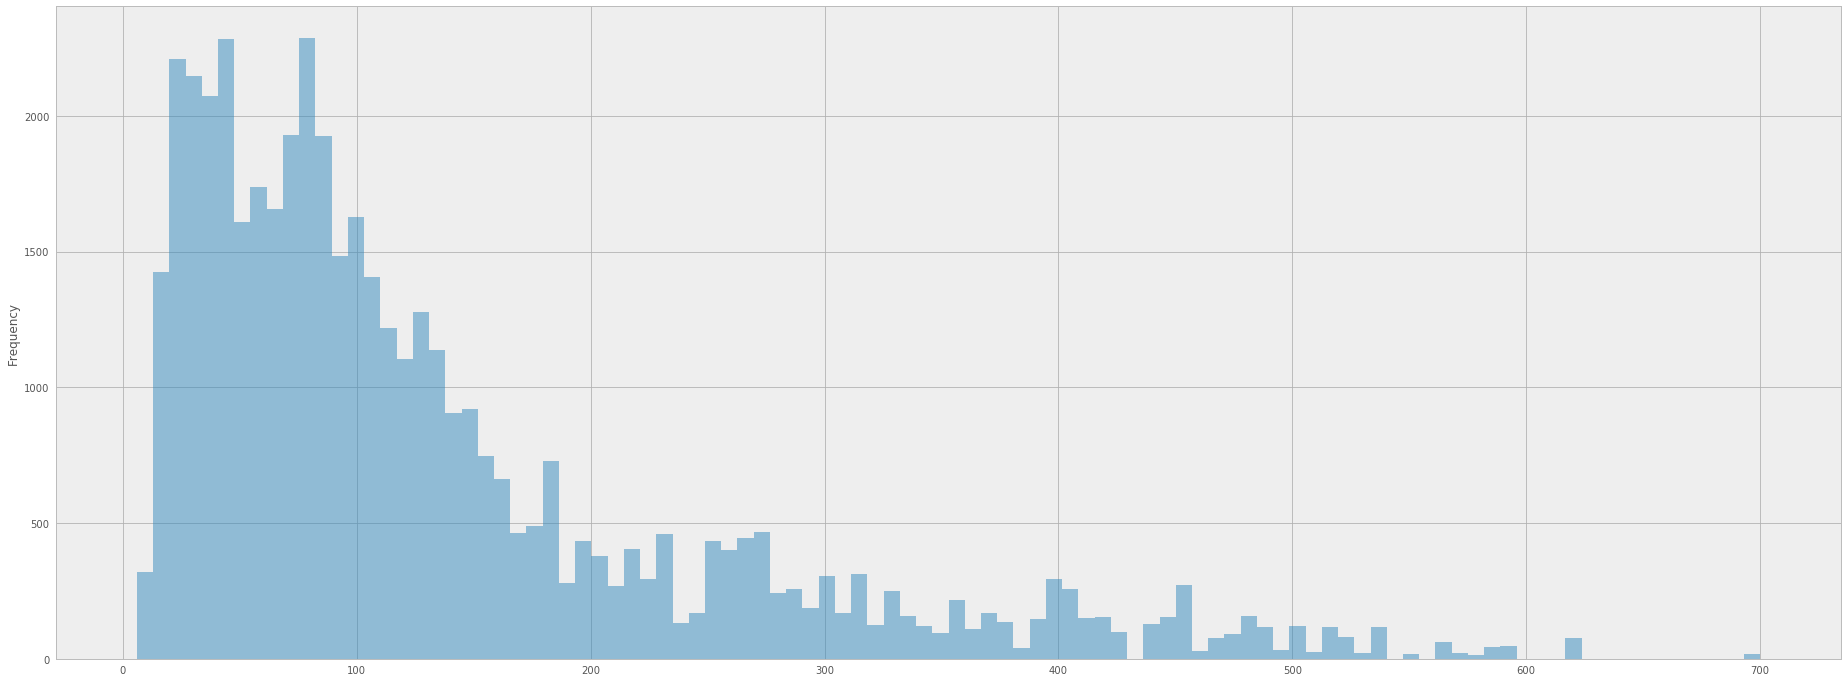

In [14]:
s_len_single.plot(kind='hist', bins=100, figsize=(32, 12), label='train', alpha=0.5)

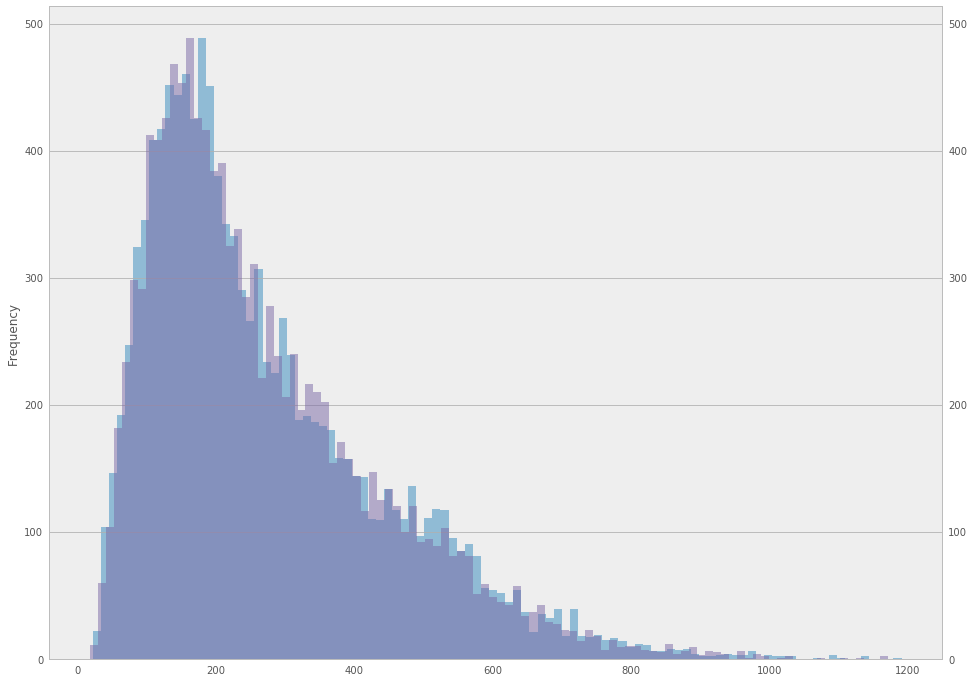

In [15]:
#df_len = pd.DataFrame({'train': pd.Series(len_train), 'test': pd.Series(len_test)})
#df_len.hist(bins=100, figsize=(32, 12))
#f = plt.figure()
s_len_train = pd.Series(len_train)
s_len_test = pd.Series(len_test)
s_len_train.plot(kind='hist', bins=100, figsize=(16, 12), label='train', alpha=0.5)
s_len_test.plot(kind='hist', bins=100, figsize=(16, 12), label='test', alpha=0.5, secondary_y=True)

In [16]:
s_len_train.describe()

count    11542.000000
mean       273.491769
std        171.779004
min         22.000000
25%        145.000000
50%        225.000000
75%        368.000000
max       1191.000000
dtype: float64

In [17]:
s_len_test.describe()

count    11542.000000
mean       270.568186
std        167.691228
min         18.000000
25%        144.000000
50%        225.000000
75%        360.000000
max       1172.000000
dtype: float64

In [18]:
s_sims_train = pd.Series([sim for (_, _, sim) in tuples_tokenids_train])
s_sims_test = pd.Series([sim for (_, _, sim) in tuples_tokenids_test])

In [19]:
pd.DataFrame({'train':s_sims_train, 'test':s_sims_test}).describe()

,test,train
count,11542.000000,11542.000000
mean,0.522378,0.523069
std,0.276300,0.275770
min,0.111111,0.111111
25%,0.333333,0.333333
50%,0.500000,0.500000
75%,0.500000,0.500000
max,1.000000,1.000000


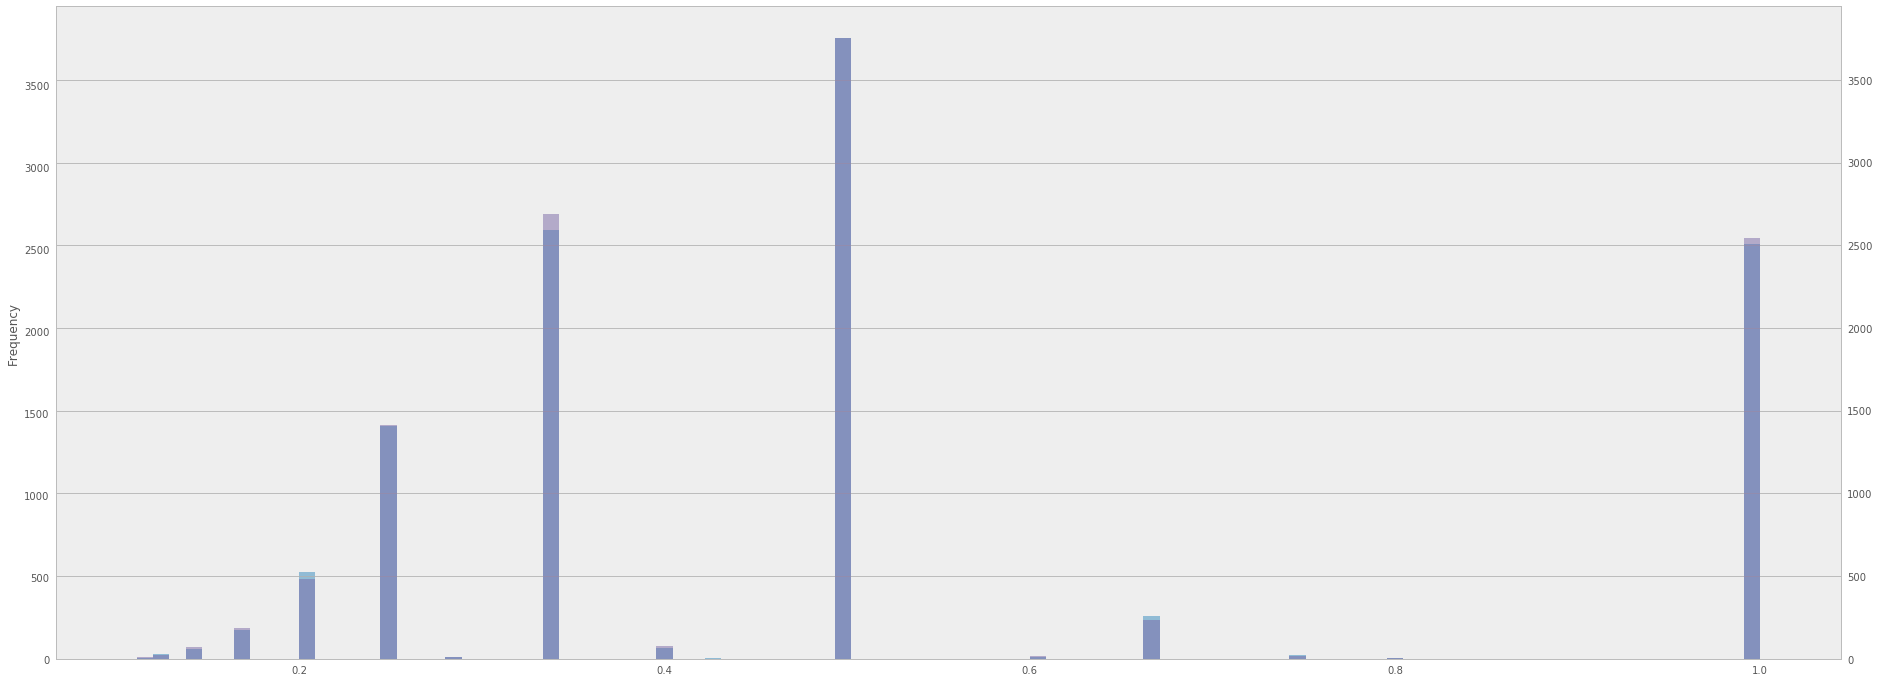

In [20]:
s_sims_train.plot(kind='hist',bins=100, figsize=(32, 12), alpha=0.5)
s_sims_test.plot(kind='hist',bins=100, figsize=(32, 12), alpha=0.5, secondary_y=True)
#df_sim = pd.DataFrame({'train': s_sims_train, 'test': s_sims_test})
#df_sim.plot(kind='hist',bins=100, figsize=(16, 12))
#df_sim.hist(bins=100, figsize=(32, 12))

In [ ]:
def print_stats(texts_train, texts_test):
    train_sentences_first_unique = set([s1 for (s1, s2, sc) in texts_train])
    train_sentences_second_unique = set([s2 for (s1, s2, sc) in texts_train])
    print('train_sentences_first_unique:\t'+str(len(train_sentences_first_unique)))
    print('train_sentences_second_unique:\t'+str(len(train_sentences_second_unique)))
    train_sentences_unique = train_sentences_first_unique
    train_sentences_unique.update(train_sentences_second_unique)
    print('train_sentences_unique:\t'+str(len(train_sentences_unique)))

    train_tuple = [s1+s2 for (s1, s2, sc) in texts_train]
    print('train_tuple duplicates: '+ str(len(train_tuple) - len(set(train_tuple))))
    print('train_tuple unique: '+ str(len(set(train_tuple))))

    test_sentences_first_unique = set([s1 for (s1, s2, sc) in texts_test])
    test_sentences_second_unique = set([s2 for (s1, s2, sc) in texts_test])
    print('test_sentences_first_unique:\t'+str(len(test_sentences_first_unique)))
    print('test_sentences_second_unique:\t'+str(len(test_sentences_second_unique)))
    test_sentences_unique = test_sentences_first_unique
    test_sentences_unique.update(test_sentences_second_unique)
    print('test_sentences_unique:\t'+str(len(test_sentences_unique)))

    test_tuple = [s1+s2 for (s1, s2, sc) in texts_test]
    print('test_tuple duplicates: '+ str(len(test_tuple) - len(set(test_tuple))))
    print('test_tuple unique: '+ str(len(set(test_tuple))))

    sentences_unique = train_sentences_unique
    sentences_unique.update(test_sentences_unique)
    print('sentences_unique:\t'+str(len(sentences_unique)))
    
    tuple_unique = set(train_tuple)
    tuple_unique.update(set(test_tuple))
    print('tuple unique: '+ str(len(tuple_unique)))
    print('train/test tuple overlap: '+ str(len(set(train_tuple)) + len(set(test_tuple)) - len(tuple_unique)))